# Feature Extraction with PCA & SVD

**Table of Contents**
<div id="toc"></div>

## Preparation

In [21]:
import ConfigParser
config = ConfigParser.ConfigParser()
config.read('config.ini')

import pandas as pd
import numpy as np
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

gtd = pd.read_csv('gtd_processed_11features.csv', encoding='latin1', low_memory=False)

In [22]:
gtd.tail(5)

,groupId,iyear,country,crit1,crit2,crit3,attacktype1,targtype1,targsubtype1,weaptype1,weapsubtype1,ransom
55563,420,2011,153,1,1,1,1,3,25.0,6.0,15.0,0.0
55564,208,2011,92,1,1,1,2,1,10.0,5.0,5.0,0.0
55565,379,2011,92,1,0,1,6,17,0.0,9.0,23.0,-9.0
55566,758,2011,153,1,1,1,9,14,67.0,13.0,0.0,0.0
55567,43,2011,182,1,1,1,2,14,67.0,5.0,5.0,0.0


In [23]:
features = gtd[['iyear', 'country', 'crit1', 'crit2', 'crit3', 'attacktype1', 'targtype1', 
                'targsubtype1', 'weaptype1', 'weapsubtype1', 'ransom']]

In [24]:
df = (pd.DataFrame(features)).to_dict(orient='records')
dv = DictVectorizer(sparse=False) 
features = dv.fit_transform(features.to_dict(orient='records'))

In [25]:
array = gtd.values
X = array[:,1:]
target = array[:,0]

## PCA

In [26]:
pca = PCA(n_components=11)
reducedPCAFeatures = pca.fit_transform(features)

### Variance

In [27]:
print pca.explained_variance_

[  2.04549917e+04   1.13099163e+03   9.31879236e+01   5.17556499e+01
   7.77422614e+00   7.02222864e+00   1.61172654e+00   7.10115969e-01
   1.00894416e-01   1.02668635e-02   2.32207774e-03]


### Variance Ratio

In [28]:
print pca.explained_variance_ratio_

[  9.40539013e-01   5.20040179e-02   4.28486499e-03   2.37977158e-03
   3.57465948e-04   3.22888422e-04   7.41086435e-05   3.26517744e-05
   4.63921647e-06   4.72079666e-07   1.06771234e-07]


### Variance Ratio Cumulative Sum

In [29]:
print pca.explained_variance_ratio_.cumsum()

[ 0.94053901  0.99254303  0.9968279   0.99920767  0.99956513  0.99988802
  0.99996213  0.99999478  0.99999942  0.99999989  1.        ]


So we would retain 99.6% of the variance with 3 components

### Refit

In [30]:
pca = PCA(n_components=3)
reducedPCAFeatures = pca.fit_transform(features)

Split for PCA:

In [31]:
X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA = train_test_split(reducedPCAFeatures, target, test_size=0.30)

## SVD:

In [32]:
svd = TruncatedSVD(n_components=10)
reducedSVDFeatures = svd.fit_transform(features)

### Variance

In [33]:
print svd.explained_variance_

[  1.63648578e+02   2.03862213e+04   1.12878603e+03   5.22045298e+01
   7.81392396e+00   7.02461402e+00   1.61814237e+00   7.27312425e-01
   1.01632540e-01   1.02926131e-02]


### Variance Ratio

In [34]:
print svd.explained_variance_ratio_

[  7.52470960e-03   9.37376886e-01   5.19026021e-02   2.40041148e-03
   3.59291289e-04   3.22998104e-04   7.44036491e-05   3.34424829e-05
   4.67315609e-06   4.73263657e-07]


### Variance Ratio Cumulative Sum

In [35]:
print svd.explained_variance_ratio_.cumsum()

[ 0.00752471  0.9449016   0.9968042   0.99920461  0.9995639   0.9998869
  0.9999613   0.99999475  0.99999942  0.99999989]


So we would also retain 99.6% of the variance with 3 components

### Refit

In [36]:
svd = TruncatedSVD(n_components=3)
reducedSVDFeatures = svd.fit_transform(features)

Split for SVD:

In [37]:
X_train_SVD, X_test_SVD, Y_train_SVD, Y_test_SVD = train_test_split(reducedSVDFeatures, target, test_size=0.30)

## Classifying

In [38]:
models = []
models.append(('KNC', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))

if config.getboolean('Booleans', 'RunPoorPerformingClassifiers') == True:
    models.append(('GNB', GaussianNB())) # GNB: 0.353792% (0.002758) - 9.339 seconds
    models.append(('LDA', LinearDiscriminantAnalysis())) #LDA: 0.285051% (0.004282) - 5.299 seconds

if config.getboolean('Booleans', 'RunRandomForest') == True:
    models.append(('RF', RandomForestClassifier()))

if config.getboolean('Booleans', 'RunSVM') == True:
    models.append(('SVM', SVC())) #Too slow for this many samples - O(N^3)

results = []
names = []
scoring = 'accuracy'
seed = 188

### PCA

In [39]:
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train_PCA, Y_train_PCA, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNC: 0.636013% (0.006355) - 2.428 seconds
DTC: 0.667661% (0.004953) - 21.527 seconds
RF: 0.660951% (0.006428) - 66.807 seconds


#### Result Plot:

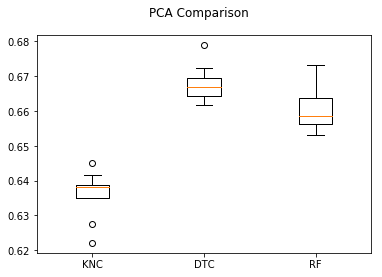

In [40]:
fig = plt.figure()
fig.suptitle('PCA Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### SVD

In [46]:
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train_SVD, Y_train_SVD, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNC: 0.643160% (0.004701) - 2.048 seconds
DTC: 0.671851% (0.004560) - 17.179 seconds
RF: 0.669871% (0.006427) - 70.466 seconds


Results:

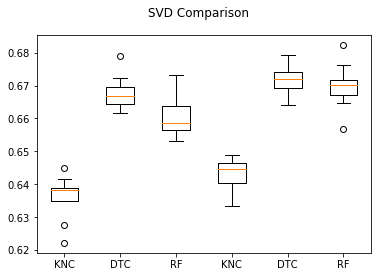

In [47]:
fig = plt.figure()
fig.suptitle('SVD Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Predicting on Validation set

In [52]:
cart = DecisionTreeClassifier()
cart.fit(X_train_SVD, Y_train_SVD)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.70073780817
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 3 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 1 0 0]]
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         1
        1.0       1.00      0.50      0.67         2
        2.0       0.75      0.75      0.75         4
        4.0       0.50      1.00      0.67         1
        5.0       0.67      0.50      0.57         4
        6.0       1.00      0.80      0.89         5
        7.0       0.00      0.00      0.00         2
        8.0       0.67      1.00      0.80         2
        9.0       0.50      1.00      0.67         2
       13.0       1.00      1.00      1.00         1
       14.0       0.33      0.25      0.29         4
       15.0       0.41      0.38      0.39        24
       16.0       0.29      0.33      0.31         6
       18.0       0.00      0.00      0.00         1
       20.0       0.40      1.00      0.57         2
       22

In [ ]:
# number = preprocessing.LabelEncoder()
# number.inverse_transform()